<a href="https://colab.research.google.com/github/takumi3682/automatestuff-ja/blob/master/Fit_Pdfs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

,年,気圧,海面気圧,降水_年,降水_日最大,降水_1h最大,降水_10min最大,気温_日平均,気温_日最高,気温_日最低,...,最大瞬間時風向,日照時間,全天日射量,降雪深,降雪深_日最大,最深積雪,雲量,雪日数,霧日数,雷日数
0,1883,NaN,1015.2,1068.1,92.7,NaN,NaN,14.3,19.4,10.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1884,NaN,1015.4,1441.0,131.5,NaN,NaN,13.5,18.6,9.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1885,NaN,1015.0,1602.6,112.5,NaN,NaN,14.4,19.1,10.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1886,NaN,1015.5,1213.2,79.2,NaN,NaN,14.9,19.5,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1887,NaN,1014.9,1185.3,133.0,NaN,NaN,14.9,20.0,10.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,2020,1005.5,1015.3,1521.5,64.0,34.0,19.0,17.7,21.8,14.2,...,南南西,2149.6,14.6,0.0,0.0,0.0,6.6,1.0,2.0,15.0
138,2021,1005.8,1015.6,2014.5,105.0,49.5,19.5,17.5,21.9,14.0,...,南南西,2179.8,14.5,0.0,0.0,0.0,6.7,11.0,0.0,15.0
139,2022,1005.5,1015.3,1058.0,55.5,22.0,13.0,17.5,21.9,13.9,...,南南東,2319.6,15.1,0.0,0.0,0.0,6.4,12.0,0.0,18.0
140,2023,1006.1,1015.9,1343.5,135.5,34.0,11.5,18.0,22.6,14.3,...,北東,2324.0,15.0,0.0,0.0,0.0,6.3,12.0,0.0,24.0


250.7 74 42.0 98


/usr/local/lib/python3.10/dist-packages/scipy/stats/_continuous_distns.py:3996: RuntimeWarning: overflow encountered in scalar divide
  sdata = -data / scale
/usr/local/lib/python3.10/dist-packages/scipy/stats/_continuous_distns.py:3894: RuntimeWarning: invalid value encountered in subtract
  weights = np.exp(logweights - maxlogw)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_continuous_distns.py:3970: RuntimeWarning: overflow encountered in scalar divide
  return -scale * (sc.logsumexp(-data / scale) - np.log(len(data)))


TypeError: len() of unsized object

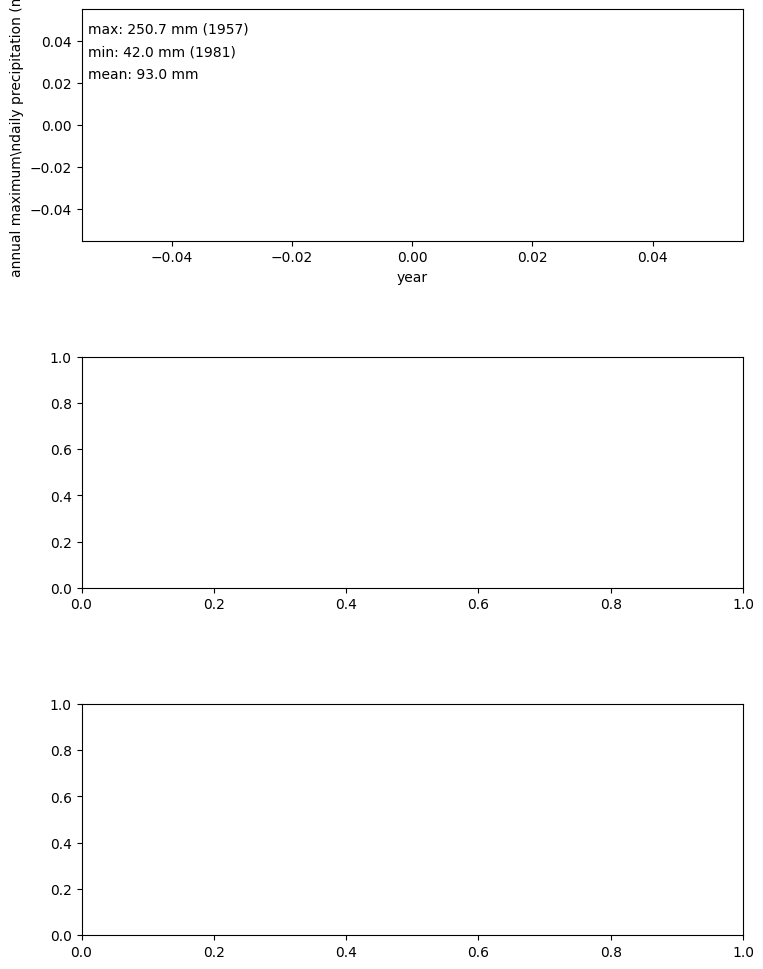

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as ss
from scipy.optimize import minimize
import pandas as pd


# -----------------------------------------------------------------------------
# --- 平方根指数型最大値分布の関数
def sqet(x, a, b):
    f = (
        a
        * b
        * 0.5
        * np.exp(
            -np.sqrt(b * x)
            - a * (1.0 + np.sqrt(b * x)) * np.exp(-np.sqrt(b * x))
        )
    )
    return f


def sqet_cdf(x, a, b):
    F = np.exp(-a * (1.0 + np.sqrt(b * x)) * np.exp(-np.sqrt(b * x)))
    return F


# SQETの対数尤度関数 (にマイナスをつけたもの)
def mL_sqet(b, data):
    n = len(data)

    sqbx = np.sqrt(b * data)
    a = (np.sum(sqbx) - 2.0 * n) / np.sum(b * data * np.exp(-sqbx))

    L = n * np.log(a) + n * np.log(b) - n * np.log(2) - np.sum(sqbx)
    L = L - a * (np.sum(np.exp(-sqbx)) + np.sum(sqbx * np.exp(-sqbx)))
    return -L


# bからaを求める式
def b2a_sqet(b, data):
    n = len(data)
    sqbx = np.sqrt(b * data)
    a = (np.sum(sqbx) - 2.0 * n) / np.sum(b * data * np.exp(-sqbx))
    return a


# -----------------------------------------------------------------------------
# データの読み込み
fp = '/content/drive/MyDrive/JMA_data/'
fn = '大阪/大阪_年data.csv'
year = []
annual_max_daily_prcp = []
i = 0
df = pd.read_csv(fp+fn, index_col=None, skiprows=0)
display(df)
#with open(fp+fn, "r") as fin:
#    for line in fin:
#        if i > 1:
#            data = line.split(",")
#            year.append(int(data[0]))
#            annual_max_daily_prcp.append(float(data[1].replace("]", "")))
#        i += 1

# ndarrayに変換
year = np.array(year)
p_max = df['降水_日最大'].max()
p_max_index = df['降水_日最大'] .argmax()
p_max_year = df['年'].values[p_max_index]

p_min = df['降水_日最大'].min()
p_min_index = df['降水_日最大'] .argmin()
p_min_year = df['年'].values[p_min_index]
print(p_max, p_max_index, p_min, p_min_index)

#annual_max_daily_prcp = np.array(annual_max_daily_prcp)

# -----------------------------------------------------------------------------
# --- プロット
# 全般の設定
fig = plt.figure(figsize=(210 / 25.4, 294 / 25.4), dpi=100)
fname_img = "histogram-and-fitted-pdf.png"

# プロット枠の設定
ax01 = fig.add_axes([0.10, 0.70, 0.80, 0.20])
ax02 = fig.add_axes([0.10, 0.40, 0.80, 0.20])
ax03 = fig.add_axes([0.10, 0.10, 0.80, 0.20])

# --- plot 1
# 年最大日降水量を西暦毎にバーグラフで表示
ax01.bar(year, annual_max_daily_prcp)

ax01.set_xlabel("year")
ax01.set_ylabel("annual maximum\\ndaily precipitation (mm)")

# グラフ上に最大値、最小値、平均値を表示
text01 = f"max: {p_max} mm "
text01 += f"({p_max_year})"
text02 = f"min: {p_min} mm "
text02 += f"({p_min_year})"
text03 = f"mean: {df['降水_日最大'].mean():.1f} mm"
fig.text(0.01, 0.90, text01, transform=ax01.transAxes)
fig.text(0.01, 0.80, text02, transform=ax01.transAxes)
fig.text(0.01, 0.70, text03, transform=ax01.transAxes)

# --- plot 2 と plot 3
# Gumbel分布を当てはめる
loc_gumbel, scale_gumbel = ss.gumbel_r.fit(p_max, method="MLE")

# 一般化極値分布を当てはめる
c_gev, loc_gev, scale_gev = ss.genextreme.fit(
    df['降水_日最大'], method="MLE"
)

# 平方根指数型最大値分布を当てはめる
res = minimize(
    mL_sqet,
    x0=[1.0],
    args=df['降水_日最大'],
    bounds=[(0, None)],
    method="Nelder-Mead",
)
b_sqet = res.x[0]
a_sqet = b2a_sqet(b_sqet, df['降水_日最大'])

gbl = ss.gumbel_r(loc=loc_gumbel, scale=scale_gumbel)
gev = ss.genextreme(c=c_gev, loc=loc_gev, scale=scale_gev)

# bin, x のためのリストを作成する
bins = [10 * (i + 1) for i in range(int(p_max / 10) + 1)]
x = np.linspace(
    0.0,
    10.0 * (int(p_max / 10) + 1),
    20 * int(p_max / 10) + 1,
)

# ヒストグラムを表示
ax02.hist(df['降水_日最大'], bins=bins, density=True)

# 当てはめた分布をプロット
ax02.plot(
    x, gbl.pdf(x), label=f"scale={scale_gumbel:.2e}, loc={loc_gumbel:.2e}"
)
ax02.plot(
    x,
    gev.pdf(x),
    label=f"scale={scale_gev:.2e}, loc={loc_gev:.2e}, c={c_gev:.2e}",
)
ax02.plot(x, sqet(x, a_sqet, b_sqet), label=f"a={a_sqet:.2e}, b={b_sqet:.2e}")

ax02.legend()

# 累積ヒストグラムを表示
ax03.hist(annual_max_daily_prcp, bins=bins, cumulative=True, density=True)
ax03.plot(x, gbl.cdf(x))
ax03.plot(x, gev.cdf(x))
ax03.plot(x, sqet_cdf(x, a_sqet, b_sqet))

ax03.set_xlabel("annual maximum daily precipitation (mm)")

# -----------------------------------------------------------------------------
# --- 図の保存
plt.savefig(fname_img, transparent=False)